##### TASK2: Explore methods for batching patterns of different length prior to presentation to a RNN and implement them. See how much speedup you can get from the GPU with minibatch training.

In sequence to sequence models batching means simultaneously encoding the inputs and processing them using our neural network either RNN, LSTM or GRU. Without batching, what we would do is it we will be processing the input one by one i.e… we encode one character after another character of the input then train the network using those encoding. In this tutorial, we will discuss how to process a batch of names for training the network.

In batching, we take multiple input names and process the characters present in these inputs simultaneously by merging them across the character level. This way we are vectorizing the inputs but not across the characters of the same name.

In [7]:
from __future__ import unicode_literals, print_function, division
from io import open
import torch
import glob
import os
import unicodedata
import string
import numpy as np
import torch.optim as optim
from IPython.display import clear_output
import unicodedata
import string

In [8]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) 
print("Configured device: ", device)

Configured device:  cuda:2


### Same from Task1

In [9]:

def findFiles(path):
    '''
    The glob module finds 
    all the pathnames matching 
    a specified pattern according 
    to the rules used by the Unix shell, 
    although results are returned 
    in arbitrary order.
    '''
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


In [10]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print("all letters: ",all_letters)
print("number of letters: ",n_letters)

all letters:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
number of letters:  57


In [11]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [12]:
# Build the category_lines dictionary, a list of names per language

category_lines = {} # dictionary of {'Arabic': [list of arabic names]}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    '''
    .split('\n')
    ['a', 'b', 'c', '']
    '''
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] #[0] -> Arabic, [1]-> .txt
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print("number of names in different languages: ", n_categories)

# Check that it worked

for c in all_categories[:2]: #only the first two languages -> arabic and chinese
    print(c)
    print(category_lines[c])

number of names in different languages:  18
Arabic
['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar', 'Nader', 'Gaber', 'Abboud', 'Maalouf', 'Zogby', 'Srour', 'Bahar', 'Mustafa', 'Hanania', 'Daher', 'Tuma', 'Nahas', 'Saliba', 'Shamoon', 'Handal', 'Baba', 'Amari', 'Bahar', 'Atiyeh', 'Said', 'Khouri', 'Tahan', 'Baba', 'Mustafa', 'Guirguis', 'Sleiman', 'Seif', 'Dagher', 'Bahar', 'Gaber', 'Harb', 'Seif', 'Asker', 'Nader', 'Antar', 'Awad', 'Srour', 'Shadid', 'Hajjar', 'Hanania', 'Kalb', 'Shadid', 'Bazzi', 'Mustafa', 'Masih', 'Ghanem', 'Haddad', 'Isa', 'Antoun', 'Sarraf', 'Sleiman', 'Dagher', 'Najjar', 'Malouf', 'Nahas', 'Naser', 'Saliba', 'Shamon', 'Malouf', 'Kalb', 'Daher', 'Maalouf', 'Wasem', 'Kanaan', 'Naifeh', 'Boutros', 'Moghadam', 'Masih', 'Sleiman', 'Aswad', 'Cham', 'Assaf', 'Quraishi', 'Shalhoub', 'Sabbag', 'Mifsud', 'Gaber', 'Shammas', 'Tan

In [13]:
import torch

# Find letter index from all_letters, e.g. "a" -> 0

def letterToIndex(letter):
    '''
    j -> 35
    o -> 14
    n -> 13
    e -> 4
    s -> 18
    '''
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    '''
    n_letter = 54
    for 'j' at index 35, 0 -> 1
    letterToIndex(letter) = 35
    '''
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    '''
    <line_length x 1 x n_letters>.
    That extra 1 dimension is because 
    PyTorch assumes everything is in batches 
    - we’re just using a batch size of 1 here.
    '''
    tensor = torch.zeros(len(line), 1, n_letters) 
    #Jones: len(line) = 5
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size()) #
# print(lineToTensor('Jones'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [19]:
## get category 
# all_categories: list of 18 languages-> at index 14  = Russia
# all_categories[top_i] = all_categories[14] = Russia
# RNN last layer has 18 neurons
def categoryFromOutput(output):
    '''
    Returns the k largest elements of 
    the given input tensor along 
    a given dimension.
    '''
    top_n, top_i = output.topk(1)
#     print("top_n: ", top_n)
#     print("top_i: ", top_i)
   
    category_i = top_i[0].item()
#     print("category_i: ", category_i)
    return all_categories[category_i], category_i

## Where batching starts

This one requires a bit of modification.

First, I consult https://www.marktechpost.com/2020/04/12/implementing-batching-for-seq2seq-models-in-pytorch/ to see how to do batching.

It turns out that our previous model takes tensor of shape (word_lenght, 1, characters) and that second dimension means the size of the batch.

Idea is we want to increase the number of 1 but all the word must have the same lenght (tensor problem) so we need to pad the smaller word to equal to the biggest word in that batch.

batched_lines function will pad all the word with all zero array after each word until the size of that word is equal to the biggest size in the list. Then pack those words into tensor.

batched_categories function is transform tags into tensor.

length of each word within the same batch has to be the same <br>
batch 1: BeauX Fabby SitXX <br>
batch 2: Film Pang Boss JoXX

In [20]:
# https://www.marktechpost.com/2020/04/12/implementing-batching-for-seq2seq-models-in-pytorch/
def batched_lines(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

def batched_categories(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = all_categories.index(lang)
    return rep

In [21]:
import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(batch_size = 1):
    if(batch_size == 1):
        category = randomChoice(all_categories)
        line = randomChoice(category_lines[category])
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line_tensor = lineToTensor(line)
        return category, line, category_tensor, line_tensor
    else:
        max_length = 0
        categories = []
        lines = []
        lines_length = []
        # Randomly choose words from our data 
        for i in range(batch_size):
            category = randomChoice(all_categories)
            line = randomChoice(category_lines[category])
            categories.append(category)
            lines.append(line)
            lines_length.append(len(line))
            # If our random word_i has the greatest length, save that number
            if(len(line) > max_length): max_length = len(line)
        # padding function
        line_tensor = batched_lines(lines,max_length)
        # just pack all the tags in to tensor form
        category_tensor = batched_categories(categories)
        return categories, lines, category_tensor, line_tensor

Lastly, the initeHidden must be able to generate hidden of (batch_size, hidden_size).

Populating the interactive namespace from numpy and matplotlib


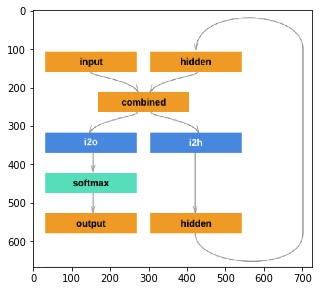

In [22]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
RNN = mpimg.imread('RNNs.png')
plt.figure(figsize = (5,5))
imgplot = plt.imshow(RNN)
plt.show()

In [23]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        # A bit more efficient than normal Softmax
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # print(input.shape, hidden.shape)
        combined = torch.cat((input, hidden), 1)
        a = self.i2h(combined)
        hidden = torch.tanh(a)
        o = self.h2o(hidden)
        y_hat = self.softmax(o)
        # hidden = self.i2h(combined)
        # output = self.i2o(combined)
        # output = self.softmax(output)
        return y_hat, hidden

    def initHidden(self, batch_size = 1):
        return torch.zeros(batch_size, self.hidden_size)

#### Loss function

In [24]:
criterion = nn.NLLLoss() 
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

#### Dataloader

In [25]:
batch_size = 4
data_loader = torch.utils.data.DataLoader(randomTrainingExample(), batch_size=batch_size,
                                               shuffle=True, num_workers=2)
num_batches = len(data_loader)
print('num_batches: ', num_batches)

num_batches:  1


In [26]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()  

In [28]:
n_hidden = 128
#     RNN(input_size, hidden_size, output_size)
# want to predict category of name input
# model therefore can take in 54 different letters and possible output of 18 different languages
# create model!
rnn = RNN(n_letters, n_hidden, n_categories) 

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

####  Plot results

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)